In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import seaborn as sns
import plotly.express as px

from sklearn.manifold import TSNE

from modules import *
input_data = InputData("ANSPRACHE_MARKETING_IMPUTED", max_twin_num = 10, kernel_size = 1) #Options: ANSPRACHE, ANSPRACHE_MARKETING_IMPUTED

There are 1 NaN values in the data which are replaced with 0s.
There are 1 NaN values in the data which are replaced with 0s.
There are 1 NaN values in the data which are replaced with 0s.
There are 1 NaN values in the data which are replaced with 0s.
There are 1 NaN values in the data which are replaced with 0s.
There are 1 NaN values in the data which are replaced with 0s.
There are 1 NaN values in the data which are replaced with 0s.


In [ ]:
# TODO: evaluieren der korrekten window positionen unter zero indexing, was sind die mindest dinger für die grid search windows, input dataen vollenden (z.B. NAs), die iid bootstraps implementieren
# alternativ den Mean Absolute Scaled Error und Symmetric Mean Absolute Percentage Error testen
#MASE: normieren des Fehlers mit mit mae eines naiven benchmarks

# FIXME: 

# NOTE: NA printout currently disabled for debugging, must be looked into later, evaluate why identical bounds from paper are not robust to all parameter combinations
#kann ich meine Ergebnisse eindeutiger machen, wenn ich mehr als 100 Testartikel nehme?
# Wie kann ich unterscheiden, ob der Fehler vom Model oder von den Twins kommt

#bias berechnung anders machen

# Window Size Analysis

[  0.   5.  13.  21.  29.  37.  45.  53.  61.  69.  77.  85.  93. 101.
 109. 117. 125. 133. 141. 149. 157. 165. 173. 181. 189. 197. 205. 213.
 221. 229. 237. 245. 253. 261. 269. 277. 285. 293. 301. 303.]
[  2.  10.  18.  26.  34.  42.  50.  58.  66.  74.  82.  90.  98. 106.
 114. 122. 130. 138. 146. 154. 162. 170. 178. 186. 194. 202. 210. 218.
 226. 234. 242. 250. 258. 266. 274. 282. 290. 298. 305. 305.]


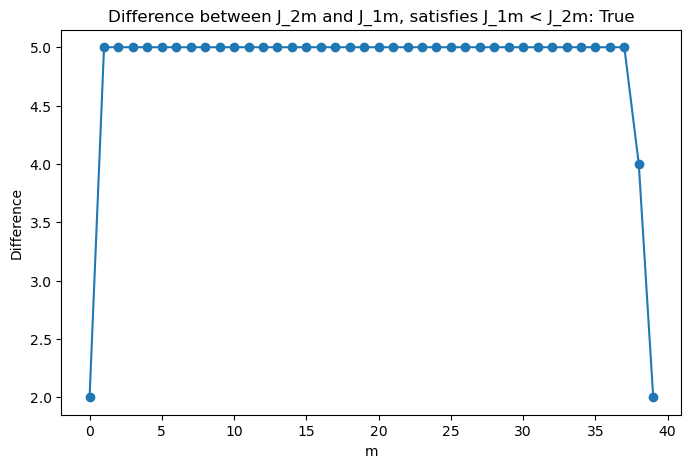

In [5]:
#sind meine windows centered oder asymmetrisch? -> den zenterpunkt +0.5 setzen
#window size dürfen nur gerade zahlen sein, sonst sind grenzen dezimalzahlen
#dadurch, dass der ub nicht inclusive ist, sind die intervalle nicht symmetrisch um den Index m*b
#was wäre eine Lösung? (abwägung zwischen symmetrischem, ungeraden intervall und asymmetrischem, geraden intervall)
#window size 1 hat die beste performance, dass müssen wir also eigentlich berücksichtigen
#-> wie verhalten sich die intervallgrenzen bei window size 1? mit den decimalzahlengrenzen
#-> vielleicht is es deshalb nicht viel besser als der standard bootstrap
N = 313
b = 8
w = 4
M = int(np.ceil(N / b))

# Compute J_1m and J_2m
J_1m_values = np.maximum(0, np.minimum(np.arange(M) * b - w/2-1, N-b - w/2))# Shape: (M,)
print(J_1m_values)
J_2m_values = np.maximum(0, np.minimum(np.arange(M) * b + w/2, N-b))    # Shape: (M,)
print(J_2m_values)

# Compute the difference
difference = J_2m_values - J_1m_values

# Plot the difference
plt.figure(figsize=(8, 5))
plt.plot(range(M), difference, marker='o', linestyle='-', label='J_2m - J_1m')
plt.xlabel('m')
plt.ylabel('Difference')
plt.title(f'Difference between J_2m and J_1m, satisfies J_1m < J_2m: {~np.any(J_1m_values >= J_2m_values)}')
plt.show()

# Empirical Test of Local Block Bootstrap

In [6]:
input_validation = InputData("ANSPRACHE_MARKETING_IMPUTED", max_twin_num = 10, kernel_size = 15)
input_validation.TwinData = input_validation.TestData

Evaluation.run_grid(input_data, output_file="method_validation")

There are 1 NaN values in the data which are replaced with 0s.
There are 1 NaN values in the data which are replaced with 0s.
There are 1 NaN values in the data which are replaced with 0s.
There are 1 NaN values in the data which are replaced with 0s.
There are 1 NaN values in the data which are replaced with 0s.
There are 1 NaN values in the data which are replaced with 0s.
There are 1 NaN values in the data which are replaced with 0s.


Parameter Grid Search:   0%|          | 0/20 [00:00<?, ?it/s]

In [8]:
df_validation = pd.read_csv("results/method_validation.csv") #method_validation
df_validation.groupby(["WINDOW_SIZE", "BLOCK_SIZE"]).median().sort_values("WASSERSTEIN").reset_index().head(10) #median, bc distribution is skewed

,WINDOW_SIZE,BLOCK_SIZE,TEST_ITEM_COMMUNICATIONKEY,TWIN_NUMBER,MEAN_SAMPLE,MEAN_TEST,BIAS,RESAMPLING_VARIANCE,TARGET_VARIANCE,CV,RMSE,MAPE,MPE,MAE,WASSERSTEIN
0,0,1,851443376.0,6.5,403.939687,337.5,56.948031,3286.973297,7.300368e+05,0.132558,220.533214,0.616538,0.251817,210.132116,213.353621
1,13,1,851443376.0,6.5,404.100026,337.5,57.773689,2472.289038,7.031013e+05,0.118151,216.564327,0.614949,0.250510,209.066077,215.380785
2,5,1,851443376.0,6.5,403.291614,337.5,57.795734,2340.312242,7.086509e+05,0.114919,218.100838,0.610066,0.254887,210.899137,215.624753
3,9,1,851443376.0,6.5,404.440010,337.5,58.738711,2432.796768,7.035786e+05,0.116594,217.355853,0.606414,0.254018,210.339506,215.766049
4,57,7,851443376.0,6.5,407.309199,337.5,68.784894,12307.895764,1.143908e+06,0.237685,250.243462,0.656647,0.253254,219.448484,217.085097
5,33,1,851443376.0,6.5,406.794712,337.5,59.466356,2632.484146,6.851622e+05,0.119226,217.817285,0.620033,0.252013,211.890223,217.120773
6,17,1,851443376.0,6.5,403.194467,337.5,58.921058,2546.970155,7.053161e+05,0.118997,216.906758,0.613312,0.248587,210.036876,217.157387
7,1,1,851443376.0,6.5,402.586424,337.5,57.519657,2238.908276,7.105815e+05,0.111448,219.499892,0.613680,0.251833,212.876117,217.184372
8,21,1,851443376.0,6.5,404.626740,337.5,59.118228,2564.533283,7.010471e+05,0.118779,216.127913,0.619178,0.249895,210.288532,217.247533
9,41,1,851443376.0,6.5,406.352536,337.5,59.156723,2654.946453,6.907042e+05,0.120143,218.438686,0.623927,0.248699,205.977903,217.646442


# Parameter Tuning

In [ ]:
#Evaluation.run_grid(input_data)
df_grid_results = pd.read_csv("results/grid_results.csv")

Parameter Grid Search:   0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
df_grid_results.groupby(["WINDOW_SIZE", "BLOCK_SIZE"]).median().drop(["TEST_ITEM_COMMUNICATIONKEY", "TWIN_NUMBER"], axis=1).sort_values("MAE").reset_index().head(20) #median, bc distribution is skewed

,WINDOW_SIZE,BLOCK_SIZE,MEAN_SAMPLE,MEAN_TEST,BIAS,RESAMPLING_VARIANCE,TARGET_VARIANCE,CV,RMSE,MAPE,MPE,MAE,WASSERSTEIN
0,57,1,405.924144,337.5,61.938158,2723.920522,690766.678758,0.120853,218.609762,0.639412,0.246578,200.490261,223.821977
1,53,1,405.928014,337.5,63.218821,2735.490735,689358.638595,0.120087,218.268922,0.630138,0.248217,203.903827,222.889397
2,49,1,406.441982,337.5,60.633507,2644.852307,688259.023193,0.120925,218.050765,0.631325,0.247973,204.271229,221.285037
3,45,1,407.285659,337.5,61.715115,2747.859235,689452.173169,0.120136,218.459803,0.628038,0.248397,207.535829,218.725292
4,53,4,407.980874,337.5,64.549135,7735.571113,957662.322755,0.195607,232.342226,0.634697,0.249479,208.043199,226.504723
5,41,1,407.710597,337.5,60.243266,2720.392233,694719.766982,0.120665,218.966148,0.625390,0.244899,208.058718,217.631952
6,37,1,406.982400,337.5,60.604044,2715.819842,687426.019827,0.120173,218.212354,0.622882,0.247274,208.660978,217.393694
7,49,4,408.031130,337.5,62.565938,7493.990512,954183.214621,0.195431,233.464938,0.634712,0.243439,208.729443,226.777420
8,57,4,408.348767,337.5,65.154003,7682.374023,958427.022784,0.196944,234.434914,0.645028,0.246854,209.159968,225.260531
9,33,1,406.220220,337.5,59.939337,2616.856033,683354.991119,0.118830,217.175959,0.622763,0.247051,209.178950,216.128238


# Trends in Parameter Configuration

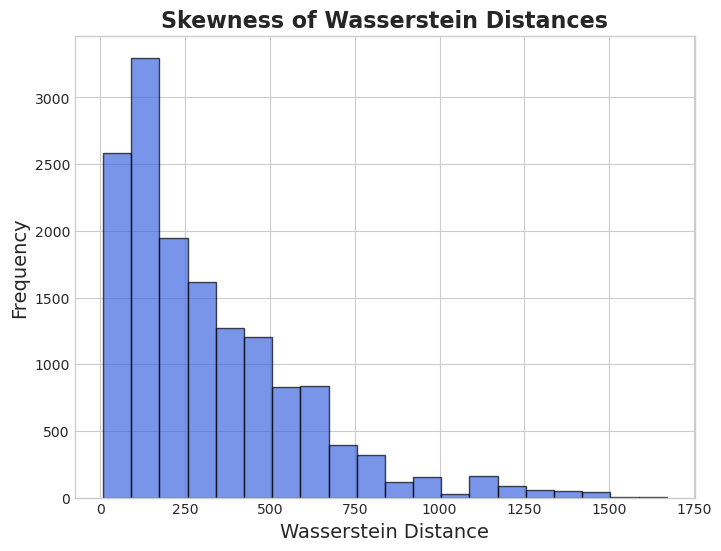

In [135]:
plt.figure(figsize=(8, 6))
plt.hist(df_grid_results.query("WINDOW_SIZE != 0")["WASSERSTEIN"], bins=20, color="royalblue", edgecolor="black", alpha=0.7)

# Labels and title
plt.xlabel("Wasserstein Distance", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.title("Skewness of Wasserstein Distances", fontsize=16, fontweight="bold")

# Show the plot
plt.show()


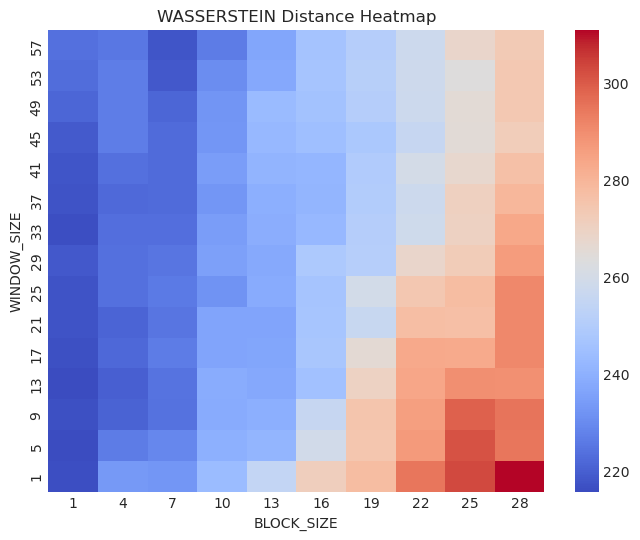

In [137]:
metric = "WASSERSTEIN"
df_heatmap = df_grid_results.query("WINDOW_SIZE != 0")\
    .groupby(["WINDOW_SIZE", "BLOCK_SIZE"]).median().reset_index()\
    .pivot(index="WINDOW_SIZE", columns="BLOCK_SIZE", values=metric).sort_index(ascending=False)

plt.figure(figsize=(8, 6))
sns.heatmap(df_heatmap.sort_index(ascending=False), cmap="coolwarm")#gray
plt.xlabel("BLOCK_SIZE")
plt.ylabel("WINDOW_SIZE")
plt.title(f"{metric} Distance Heatmap")
plt.show()

### Fazit
- im BIAS ist keine Struktur auf Grund verschiedener Parameter zu erkennen
- in der VARIANCE ist die Struktur deutlich
- Haupteinfluss in der Wasserstein Evaluierung ist die Varianz    
-> ist der Moving Bootstrap trotzdem noch besser, als der  IID Bootstrap (Vergleich von BIAS und Varianz)

# Best Parameter Configuration vs. Benchmark

In [ ]:
best_params = (1, 1)

results  = []
for test_item_key in input_data.TestData.keys():
    results.append(Evaluation.run_lbb(input_data.TwinData[test_item_key], input_data.TestData[test_item_key], test_item_key, *best_params))
    results.append(Evaluation.run_idd(input_data.TwinData[test_item_key], input_data.TestData[test_item_key], test_item_key))

df_results = pd.DataFrame(results)

In [ ]:
# best params
df_results.query( f"BLOCK_SIZE == {best_params[1]} & WINDOW_SIZE == {best_params[0]}")
#benchmark
df_results.query("BLOCK_SIZE == 1 & WINDOW_SIZE == 0")

,TEST_ITEM_COMMUNICATIONKEY,BLOCK_SIZE,WINDOW_SIZE,TWIN_NUMBER,MEAN_SAMPLE,MEAN_TEST,BIAS,RESAMPLING_VARIANCE,TARGET_VARIANCE,CV,RMSE,MAPE,MPE,MAE,WASSERSTEIN
0,716679764,1,1,9,673.983426,372.0,301.983426,9474.568872,2.431562e+06,0.144421,317.283089,0.811827,0.811783,301.999574,320.000927
2,718909161,1,1,6,366.686093,426.0,-59.313907,2285.866622,1.381797e+05,0.130386,76.184029,0.152296,-0.139235,64.878133,62.116958
4,735286989,1,1,7,579.285958,530.0,49.285958,2292.949839,1.053928e+05,0.082662,68.717214,0.106642,0.092992,56.520412,56.751147
6,752591985,1,1,6,307.340953,18.0,289.340953,2276.788123,2.171579e+06,0.155253,293.248999,16.074497,16.074497,289.340953,290.798976
8,756589959,1,1,5,446.192998,198.0,248.192998,1716.830097,1.445577e+06,0.092863,251.627889,1.253500,1.253500,248.192998,253.589222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,1602841085,1,1,6,155.388691,220.0,-64.611309,398.077357,1.190786e+05,0.128400,67.621732,0.293764,-0.293688,64.627996,65.540399
192,1603782512,1,1,6,311.016118,473.0,-161.983882,1323.332973,5.404284e+05,0.116964,166.018405,0.342461,-0.342461,161.983882,163.612201
194,1617994924,1,1,10,447.873886,213.0,234.873886,2645.225614,7.940994e+05,0.114835,240.439115,1.102694,1.102694,234.873886,238.488880
196,1617995015,1,1,6,213.383592,69.0,144.383592,684.903041,6.048143e+05,0.122646,146.736242,2.092516,2.092516,144.383592,145.484169


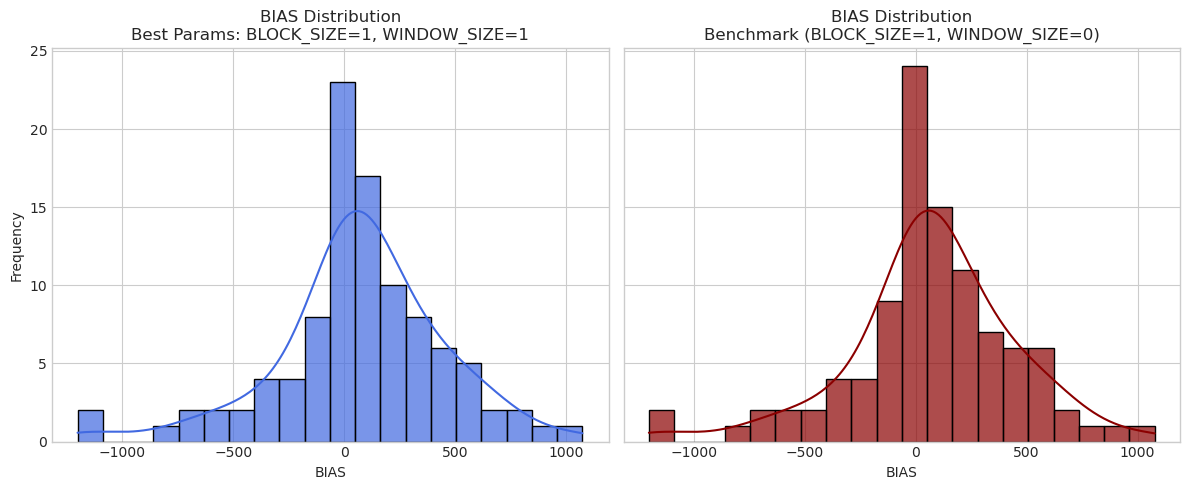

In [ ]:
# Create side-by-side histograms with KDE
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

# Best parameters plot
sns.histplot(df_results.query( f"BLOCK_SIZE == {best_params[1]} & WINDOW_SIZE == {best_params[0]}")["BIAS"], bins=20, kde=True, color="royalblue", edgecolor="black", ax=axes[0], alpha=0.7)
axes[0].set_title(f"BIAS Distribution\nBest Params: BLOCK_SIZE={best_params[1]}, WINDOW_SIZE={best_params[0]}")
axes[0].set_xlabel("BIAS")
axes[0].set_ylabel("Frequency")

# Benchmark plot
sns.histplot(df_results.query("BLOCK_SIZE == 1 & WINDOW_SIZE == 0")["BIAS"], bins=20, kde=True, color="darkred", edgecolor="black", ax=axes[1], alpha=0.7)
axes[1].set_title("BIAS Distribution\nBenchmark (BLOCK_SIZE=1, WINDOW_SIZE=0)")
axes[1].set_xlabel("BIAS")
axes[1].set_ylabel("")  # No duplicate ylabel

# Adjust layout
plt.tight_layout()
plt.show()

In [119]:
#vergleich der histogramme der BIAS mit aggregierter Metric
#vergleich der histogramme der varianzen mit aggregierter Metric
df_grid_results.query(f"{best_params}")

,TEST_ITEM_COMMUNICATIONKEY,BLOCK_SIZE,WINDOW_SIZE,TWIN_NUMBER,MEAN_SAMPLE,MEAN_TEST,BIAS,RESAMPLING_VARIANCE,TARGET_VARIANCE,CV,RMSE,MAPE,MPE,MAE,WASSERSTEIN
1,718909161,1,1,6,368.377854,426.0,-57.622146,2216.122171,131809.300617,0.127792,74.407216,0.148352,-0.135263,63.198083,60.17096
1,718909161,1,1,6,368.377854,426.0,-57.622146,2216.122171,131809.300617,0.127792,74.407216,0.148352,-0.135263,63.198083,60.17096


In [ ]:
#was interessiert uns?
# verteilung von BIAS und der Varianz zwischen den beiden Verfahren
#Vermutung: der Moving Bootstrap kann den BIAS reduzieren, da er den Zeitverlauf besser berücksichtigt
#Der Moving Bootstrap ist dann auf jeden Fall kein Ziehen mit zurücklegen mehr...

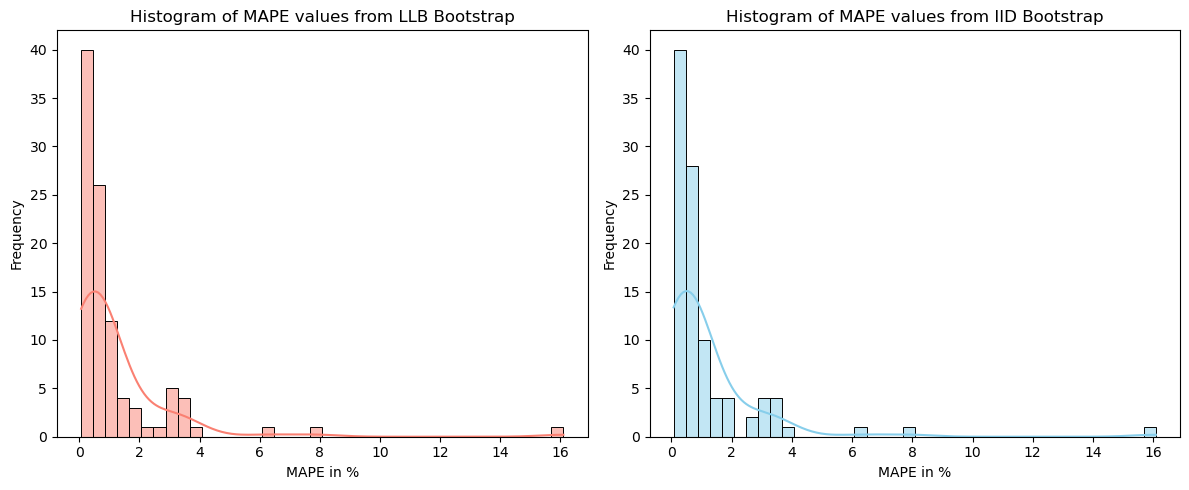

In [12]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df_results.query("WINDOW_SIZE != 0")["MAPE"], bins=40, kde=True, color='salmon')
plt.xlabel("MAPE in %")
plt.ylabel("Frequency")
plt.title("Histogram of MAPE values from LLB Bootstrap")

plt.subplot(1, 2, 2)
sns.histplot(df_results.query("WINDOW_SIZE == 0")["MAPE"], bins=40, kde=True, color="skyblue")
plt.xlabel("MAPE in %")
plt.ylabel("Frequency")
plt.title("Histogram of MAPE values from IID Bootstrap")

plt.tight_layout()
plt.show()

# Optimal Twin Size
- Trade off: few twins means having only the most similar products but also increases chance to miss out on variation

# Error Analysis
- How can we deal with the slight bias in our result?
- Identifying and analysing outlier items -> 3 Error types: twins way to high, twins way to low, different seasonality curves

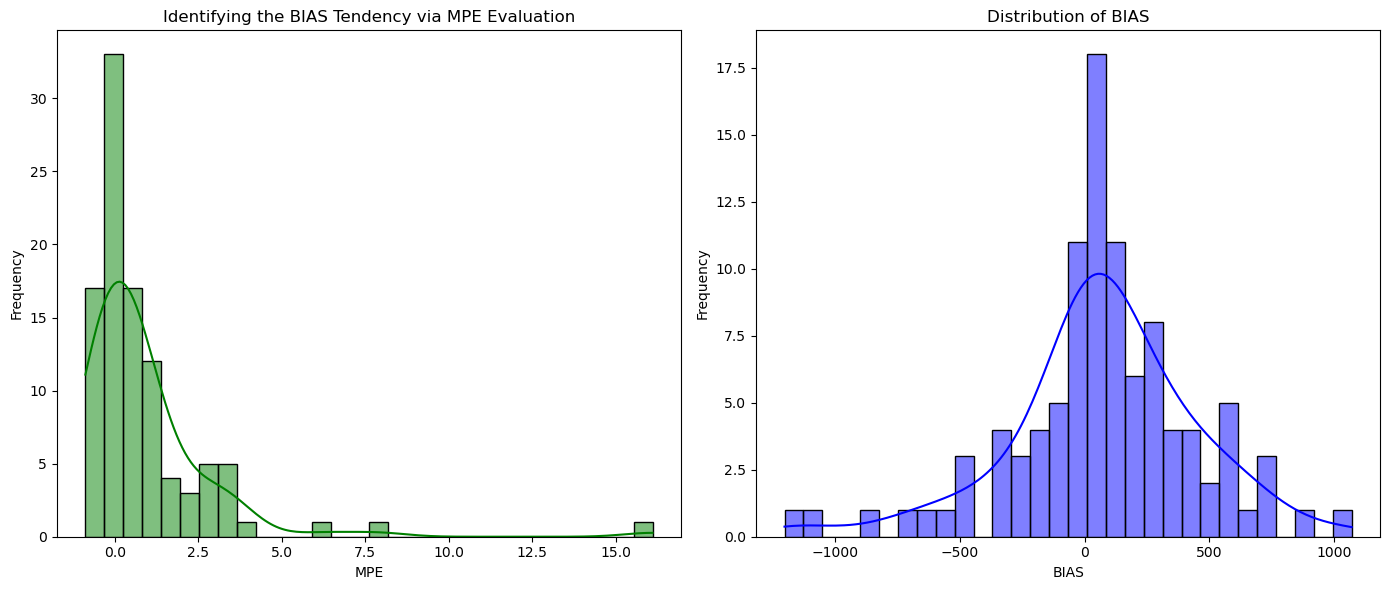

In [ ]:
#note: mape is not symmetric!
# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# First subplot: LBB_MPE histogram
sns.histplot(df_results.query("WINDOW_SIZE != 0")["MPE"], bins=30, kde=True, color="green", ax=axes[0])
axes[0].set_xlabel("MPE")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Identifying the BIAS Tendency via MPE Evaluation")

# Second subplot: BIAS histogram
sns.histplot(df_results.query("WINDOW_SIZE != 0")["BIAS"], bins=30, kde=True, color="blue", ax=axes[1])
axes[1].set_xlabel("BIAS")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Distribution of BIAS")

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()
#wenn man range kennt -> null sollte mitte des bins sein, oder bin genau an der grenze -> sich dynamisch ändern bei neuem input

# Best Local Parameters

In [15]:
df_grid_results.sort_values("MAPE").head(20) #median, bc distribution is skewed

,TEST_ITEM_COMMUNICATIONKEY,BLOCK_SIZE,WINDOW_SIZE,TWIN_NUMBER,MEAN_SAMPLE,MEAN_TEST,BIAS,RESAMPLING_VARIANCE,TARGET_VARIANCE,CV,RMSE,MAPE,MPE,MAE,WASSERSTEIN
6799,850575936,1,1,7,1424.674461,1414.0,10.674461,10292.649004,290629.457872,0.071211,102.012711,0.057996,0.007549,82.006890,57.061742
6804,850575936,1,5,7,1424.426116,1414.0,10.426116,12365.394690,348369.427721,0.078066,111.687504,0.062766,0.007373,88.751831,46.980089
6809,850575936,1,9,7,1424.185439,1414.0,10.185439,13798.817306,388262.589913,0.082481,117.909120,0.066292,0.007203,93.737216,45.963738
6814,850575936,1,13,7,1427.003509,1414.0,13.003509,14367.112126,405958.937066,0.083996,120.566178,0.067361,0.009196,95.248486,47.789228
6819,850575936,1,17,7,1427.041045,1414.0,13.041045,14915.684040,421306.417955,0.085583,122.824073,0.068966,0.009223,97.517637,50.438412
6829,850575936,1,25,7,1429.427850,1414.0,15.427850,14989.968241,425279.017073,0.085652,123.401729,0.069413,0.010911,98.149765,48.020540
6839,850575936,1,33,7,1431.342651,1414.0,17.342651,15540.593037,442409.286785,0.087094,125.862467,0.070321,0.012265,99.434141,46.454503
6824,850575936,1,21,7,1429.588072,1414.0,15.588072,15512.603464,440013.657059,0.087123,125.521279,0.070754,0.011024,100.046119,50.585406
6834,850575936,1,29,7,1435.069678,1414.0,21.069678,15761.820834,452586.586811,0.087484,127.301815,0.070757,0.014901,100.050206,51.102941
13591,1594262232,1,1,10,1051.607816,1010.0,41.607816,6378.980499,113253.003767,0.075949,90.056598,0.071261,0.041196,71.974090,70.125487


In [16]:
input_data.TestData.keys()

dict_keys([716679764, 718909161, 735286989, 752591985, 756589959, 796628327, 803582159, 803603891, 806267522, 807443786, 807444058, 807444298, 811224241, 811405342, 811408901, 811579051, 813036796, 822088318, 824003149, 824008632, 824014002, 824203823, 829556735, 829628090, 831771058, 832176270, 833087665, 836346869, 836349509, 836354525, 837663879, 837937579, 837976432, 837978298, 838102710, 840794521, 842058910, 842059288, 845339708, 845938731, 847089647, 847101662, 847909963, 848764870, 850549205, 850561732, 850561943, 850562202, 850564755, 850575936, 852310816, 854638267, 855312233, 856030824, 856065671, 860861951, 863505500, 867948791, 868158733, 868192553, 869458445, 869459445, 943969594, 943981017, 1045359838, 1061284288, 1061289615, 1062867487, 1064483626, 1064587225, 1064614421, 1066797131, 1085302391, 1085391770, 1088115601, 1088136910, 1092083846, 1105152913, 1178366721, 1182041425, 1276335264, 1281740511, 1288996309, 1402591736, 1447265146, 1462081956, 1556774133, 156169546

In [70]:
df_grid_results.query("TEST_ITEM_COMMUNICATIONKEY == 807444058").sort_values("WASSERSTEIN")
#Order by Wasserstein
#Benchmark best: 716679764
#Random: 796628327, 803603891, 807444298, 811224241, 
#Moving Bootstrap best: 807443786

,TEST_ITEM_COMMUNICATIONKEY,BLOCK_SIZE,WINDOW_SIZE,TWIN_NUMBER,MEAN_SAMPLE,MEAN_TEST,BIAS,RESAMPLING_VARIANCE,TARGET_VARIANCE,CV,RMSE,MAPE,MPE,MAE,WASSERSTEIN
1545,807444058,1,29,5,199.180443,246.0,-46.819557,575.897785,69544.057260,0.120483,52.611488,0.192812,-0.190323,47.431685,46.833501
1550,807444058,1,33,5,199.027679,246.0,-46.972321,580.797822,70027.150572,0.121087,52.793908,0.193888,-0.190944,47.696489,47.212236
1555,807444058,1,37,5,199.158286,246.0,-46.841714,577.096045,69626.301782,0.120622,52.642590,0.192830,-0.190413,47.436204,47.695286
1530,807444058,1,17,5,198.222962,246.0,-47.777038,565.781382,71565.668451,0.119997,53.370654,0.196363,-0.194216,48.305296,48.017521
1540,807444058,1,25,5,198.134285,246.0,-47.865715,555.072329,71509.747869,0.118909,53.349780,0.196893,-0.194576,48.435672,48.148765
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2110,807444058,25,1,5,198.649715,246.0,-47.350285,5949.788765,205795.184492,0.388296,90.508775,0.307770,-0.192481,75.711482,90.148678
2200,807444058,28,13,5,198.567956,246.0,-47.432044,7016.262030,232780.340904,0.421836,96.260380,0.332534,-0.192813,81.803383,90.958893
2195,807444058,28,9,5,196.628833,246.0,-49.371167,6570.392531,226296.246247,0.412238,94.909982,0.326952,-0.200696,80.430076,91.045740
2190,807444058,28,5,5,196.841730,246.0,-49.158270,6556.290039,225414.930801,0.411350,94.724999,0.325009,-0.199830,79.952148,92.955158


In [ ]:
df_grid_results.query("WINDOW_SIZE == 0").groupby("TEST_ITEM_COMMUNICATIONKEY").median().sort_values("MAPE", ascending=True).reset_index()[["TEST_ITEM_COMMUNICATIONKEY", "MAPE", "MPE"]].head(30)
#Hauptfehlerquellen:
# Twins haben deutlich höhere Ansprache als der Testartikel
# Saisonkurven passen nicht
# Twins haben deutlich niedrigere Ansprache als der Testartikel

,TEST_ITEM_COMMUNICATIONKEY,MAPE,MPE
0,850575936,0.077910,0.009771
1,1088115601,0.090093,0.060298
2,811408901,0.091641,-0.070926
3,1594262232,0.092005,0.042409
4,850562202,0.092968,-0.058984
5,1085391770,0.098576,-0.018353
6,869458445,0.113029,0.092615
7,868192553,0.113356,-0.061903
8,811405342,0.113951,0.089384
9,836346869,0.117494,0.066987


# Experiments

- Apply smoothing function on input time series, Idee: summer verändert sich nicht, risiko peaks zu samplen geht runter
-> ist vielleicht eine ganz glatte serie besser geeignet, um blöcke zu samplen -> dann ist der input weniger random
- Ansprache Marketing Imputed -> nahezu keine Auswirkung, dazu keine Verbesserung
- Influence of number of twins
- Change of observation period, change of product group
- Einfluss von NAs auf den Fehler -> quasi keine NAs mehr, wenn wir bei FirstSoldout strikt cutten
- Einfluss von Soldout auf den Fehler


# Normality test
- clt is defined for iid data
- distributions moments must be finite?
- tune number of iteration until distribution is normal -> helps simplify methods of robust optimization

In [ ]:
samples = Resampling.lb_bootstrap(input_data.TestData[804245827], 14, 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot the histogram
ax1.hist(samples, bins=50, density=True, alpha=0.6, color='grey', edgecolor='black', label='Bootstrap PDF')
ax1.set_title('Histogram of Bootstrapped Values')
ax1.set_xlabel('Value')
ax1.set_ylabel('Density')

# Remove top and right spines for the histogram
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Calculate the normal PDF
x = np.linspace(min(samples), max(samples), 100)
normal_pdf = stats.norm.pdf(x, loc=np.mean(samples), scale=np.sqrt(np.var(samples, ddof = 1)))

# Plot the normal PDF
ax1.plot(x, normal_pdf, label='Normal PDF', color='black', linestyle='-')

# Plot the empirical CDF
data_sorted = np.sort(samples)
# Calculate the ECDF values
ecdf = np.arange(1, len(data_sorted) + 1) / len(data_sorted)
ax2.plot(data_sorted, ecdf, marker='o', linestyle='none', color='grey', label='Bootstrap CDF')

# Remove top and right spines for the CDF
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Calculate the normal CDF
normal_cdf = stats.norm.cdf(x, loc=np.mean(samples), scale=np.sqrt(np.var(samples, ddof = 1)))

# Plot the normal CDF
ax2.plot(x, normal_cdf, label='Normal CDF', color='black', linestyle='-')

ax2.set_title('Empirical CDF vs Normal CDF')
ax2.set_xlabel('Value')
ax2.set_ylabel('Cumulative Probability')

# Add legends
ax1.legend()
ax2.legend()

plt.tight_layout()
plt.savefig('plots/bootstrap_joint_distribution.svg')
plt.show()


KeyError: 804245827

In [ ]:
#H0: the data is normally distributed
#define alpha level
alpha = 0.05

In [ ]:
#generate integer samples from normal distribution
norm_samples = np.random.normal(50, 25, 100000).astype(int)

In [ ]:
_, p_value = stats.normaltest(samples)
print(p_value)
if p_value > alpha:
    print("Fail to reject the null hypothesis: The data appears to be normally distributed.")
else:
    print("Reject the null hypothesis: The data does NOT appear to be normally distributed.")

5.071147263410315e-08
Reject the null hypothesis: The data does NOT appear to be normally distributed.


In [ ]:
# Warning: for N > 5000, computed p-value may not be accurate.
_, p_value = stats.shapiro(samples)
print(p_value)
if p_value > alpha:
    print("Fail to reject the null hypothesis: The data appears to be normally distributed.")
else:
    print("Reject the null hypothesis: The data does not appear to be normally distributed.")

5.705737762718961e-07
Reject the null hypothesis: The data does not appear to be normally distributed.
